# Home Energy Management via Convex Optimization

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import datetime
import pandas as pd
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import calendar
import tqdm

# Customize plot settings
from latexify import *
from utils import *
golden_mean = (np.sqrt(5) - 1.0) / 2.0  # Aesthetic ratio

## Problem data

In [2]:
# Hourly loads
load_data = pd.read_pickle("data/load_data.pickle")
load_min = load_data.min()
load_max = load_data.max()

# Time-of-use prices
tou_price_data = pd.read_pickle("data/tou_price_data.pickle")

# Day-ahead spot prices
spot_prices_2020_2022 = pd.read_pickle("data/spot_price_data.pickle")
spot_prices_jan2023 = pd.read_pickle("data/spot_price_data_jan2023.pickle")
spot_price_data = pd.concat([spot_prices_2020_2022, spot_prices_jan2023])

# Load forecasting
load_baseline = pd.read_pickle("data/load_baseline.pickle")
AR_params = pd.read_pickle("data/AR_params.pickle")

# Spot price forecasting
spot_price_baseline = pd.read_pickle("data/spot_price_baseline.pickle")

# Define simulation window: one year (2022) with hourly resolution
T = 24 * 365
start_date = pd.Timestamp("2022-01-01 00:00:00")

sim_start_time = load_baseline.index.get_loc(start_date)
sim_end_time = sim_start_time + T
sim_datetime_index = load_data.index[sim_start_time:sim_end_time]

# Load and price values for 2022
load = load_data.iloc[sim_start_time:sim_end_time].values
tou_prices = tou_price_data.iloc[sim_start_time:sim_end_time].values
spot_prices = spot_price_data.iloc[sim_start_time:sim_end_time].values

## Constants

In [3]:
P = 20 # Maximum power extracted form the grid
eff_s = (1-0.015)**(1/720) # Storing efficiency (1% loss per month)
eff_c, eff_d = 0.95, 0.95 # Charging and discharging efficiencies

# Affine peak power cost parameters
a, b = 20.35, 83

# Tiered peak power cost parameters
tiers = [0, 1, 2, 3, 4]
tier_costs = np.array([83, 147, 252, 371, 490])
tier_z_upper_bounds = np.array([2, 5, 10, 15, P])


## Baseline analysis: no storage

In [ ]:
# Tiered peak power cost
total_tou_cost, total_spot_cost, total_peak_cost = compute_total_costs(tou_prices=tou_prices, spot_prices=spot_prices, power=load, datetime_index=sim_datetime_index, peak_cost_function=tiered_peak_cost_function, N=3)
cost_no_storage_tiered = total_tou_cost + total_spot_cost + total_peak_cost
print_cost_summary(total_tou_cost, total_spot_cost, total_peak_cost)
monthly_tou_costs_tiered, monthly_spot_costs_tiered, monthly_peak_costs_tiered = compute_monthly_costs(tou_prices=tou_prices, spot_prices=spot_prices, power=load, datetime_index=sim_datetime_index, peak_cost_function=tiered_peak_cost_function, N=3)

# Plot monthly cost breakdown for tiered peak power cost functions
latexify(fig_width=5)
fig, ax = plt.subplots()
bar_width = 0.8

months = np.arange(1, 13)

plt.bar(months, monthly_tou_costs_tiered, bar_width, color="tab:blue", label='Energy cost (time-of-use prices)')
plt.bar(months, monthly_spot_costs_tiered, bar_width, bottom=monthly_tou_costs_tiered, color="tab:orange", label='Energy cost (day-ahead spot prices)')
plt.bar(months, monthly_peak_costs_tiered, bar_width, bottom=[i+j for i,j in zip(monthly_tou_costs_tiered, monthly_spot_costs_tiered)], color="tab:green", label='Peak power cost')

plt.xticks(months, [calendar.month_abbr[m] for m in range(1, 13)])
plt.ylabel('Cost (NOK)')
plt.legend()

plt.savefig("figures/costs_no_storage.pdf")


## Prescient problem (perfect knowledge of the future)

### Solution via a MICP solver

In [41]:
# Constants
P = 20
Q = 20
eff_s, eff_c, eff_d = 0.99998, 0.95, 0.95
C, D, q_init, q_final = Q/2, Q/2, Q/2, Q/2
c_values = np.array([83, 147, 252, 371, 490])
T_values = np.array([2, 5, 10, 15, 20])

# Variables
p = cp.Variable(T)  # Grid power
c = cp.Variable(T)  # Charging battery power
d = cp.Variable(T)  # Discharging battery power
q = cp.Variable(T+1)  # State of charge

# Constraints
cons = [0 <= p, p <= P,
        load + c == p + d,
        q[1:] == eff_s * q[:-1] + eff_c * c - d / eff_d,
        q[0] == q_init, q[-1] == q_final,
        0 <= q, q <= Q,
        0 <= c, c <= C,
        0 <= d, d <= D]

energy_cost = cp.sum(cp.multiply(tou_prices + spot_prices, p))

z_values = compute_month_z_values(p, sim_datetime_index)
peak_power_cost = 0
y_values = [] 
for z in z_values:
    y = cp.Variable(5, boolean=True)
    y_values.append(y)
    peak_power_cost += cp.matmul(c_values, y)
    cons += [z <= cp.matmul(T_values, y), cp.sum(y) == 1]

cost = energy_cost + peak_power_cost
problem = cp.Problem(cp.Minimize(cost), cons)
problem.solve()

p_prescient = p.value
q_prescient = q.value
y_values_array = np.array([y.value for y in y_values])

print("Optimal value for original MICP problem:", cost.value)
print("Optimal y for original MICP problem::\n", y_values_array)

Optimal value for original MICP problem: 21956.868122488224
Optimal y for original MICP problem::
 [[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


### Perspective relaxation

In [44]:
# Constants
P = 20
Q = 20
eff_s, eff_c, eff_d = 0.99998, 0.95, 0.95
C, D, q_init, q_final = Q/2, Q/2, Q/2, Q/2
c_values = np.array([83, 147, 252, 371, 490])
T_values = np.array([2, 5, 10, 15, 20])

# Variables
p = cp.Variable(T)  # Grid power
c = cp.Variable(T)  # Charging battery power
d = cp.Variable(T)  # Discharging battery power
q = cp.Variable(T+1)  # State of charge

# Constraints
cons = [0 <= p, p <= P,
        load + c == p + d,
        q[1:] == eff_s * q[:-1] + eff_c * c - d / eff_d,
        q[0] == q_init, q[-1] == q_final,
        0 <= q, q <= Q,
        0 <= c, c <= C,
        0 <= d, d <= D]

energy_cost = cp.sum(cp.multiply(tou_prices + spot_prices, p))

# Redefine the y variables as continuous variables between 0 and 1
y_values = []
for z in z_values:
    y = cp.Variable(5)
    y_values.append(y)
    peak_power_cost += cp.matmul(c_values, y)
    # Add perspective constraint
    cons += [z * cp.norm(y, 1) <= cp.matmul(T_values, y), cp.sum(y) == 1, 0 <= y, y <= 1]

# Create and solve the relaxed problem
cost = energy_cost + peak_power_cost
problem = cp.Problem(cp.Minimize(cost), cons)
problem.solve()

print("Lower bound (relaxed problem):", cost.value)


DCPError: Problem does not follow DCP rules. Specifically:
The following constraints are not DCP:
(sum_largest(Hstack(reshape(max(var351428[ True  True  True ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F)), 3) / 3.0) @ norm1(var358509) <= [ 2.  5. 10. 15. 20.] @ var358509 , because the following subexpressions are not:
|--  (sum_largest(Hstack(reshape(max(var351428[ True  True  True ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F)), 3) / 3.0) @ norm1(var358509)
(sum_largest(Hstack(reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F)), 3) / 3.0) @ norm1(var358534) <= [ 2.  5. 10. 15. 20.] @ var358534 , because the following subexpressions are not:
|--  (sum_largest(Hstack(reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F)), 3) / 3.0) @ norm1(var358534)
(sum_largest(Hstack(reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F)), 3) / 3.0) @ norm1(var358559) <= [ 2.  5. 10. 15. 20.] @ var358559 , because the following subexpressions are not:
|--  (sum_largest(Hstack(reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F)), 3) / 3.0) @ norm1(var358559)
(sum_largest(Hstack(reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F)), 3) / 3.0) @ norm1(var358584) <= [ 2.  5. 10. 15. 20.] @ var358584 , because the following subexpressions are not:
|--  (sum_largest(Hstack(reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F)), 3) / 3.0) @ norm1(var358584)
(sum_largest(Hstack(reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F)), 3) / 3.0) @ norm1(var358609) <= [ 2.  5. 10. 15. 20.] @ var358609 , because the following subexpressions are not:
|--  (sum_largest(Hstack(reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F)), 3) / 3.0) @ norm1(var358609)
(sum_largest(Hstack(reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F)), 3) / 3.0) @ norm1(var358634) <= [ 2.  5. 10. 15. 20.] @ var358634 , because the following subexpressions are not:
|--  (sum_largest(Hstack(reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F)), 3) / 3.0) @ norm1(var358634)
(sum_largest(Hstack(reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F)), 3) / 3.0) @ norm1(var358659) <= [ 2.  5. 10. 15. 20.] @ var358659 , because the following subexpressions are not:
|--  (sum_largest(Hstack(reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F)), 3) / 3.0) @ norm1(var358659)
(sum_largest(Hstack(reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F)), 3) / 3.0) @ norm1(var358684) <= [ 2.  5. 10. 15. 20.] @ var358684 , because the following subexpressions are not:
|--  (sum_largest(Hstack(reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F)), 3) / 3.0) @ norm1(var358684)
(sum_largest(Hstack(reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F)), 3) / 3.0) @ norm1(var358709) <= [ 2.  5. 10. 15. 20.] @ var358709 , because the following subexpressions are not:
|--  (sum_largest(Hstack(reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F)), 3) / 3.0) @ norm1(var358709)
(sum_largest(Hstack(reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F)), 3) / 3.0) @ norm1(var358734) <= [ 2.  5. 10. 15. 20.] @ var358734 , because the following subexpressions are not:
|--  (sum_largest(Hstack(reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F)), 3) / 3.0) @ norm1(var358734)
(sum_largest(Hstack(reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F)), 3) / 3.0) @ norm1(var358759) <= [ 2.  5. 10. 15. 20.] @ var358759 , because the following subexpressions are not:
|--  (sum_largest(Hstack(reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F)), 3) / 3.0) @ norm1(var358759)
(sum_largest(Hstack(reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ...  True  True  True], None, False), (1,), F)), 3) / 3.0) @ norm1(var358784) <= [ 2.  5. 10. 15. 20.] @ var358784 , because the following subexpressions are not:
|--  (sum_largest(Hstack(reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ... False False False], None, False), (1,), F), reshape(max(var351428[False False False ...  True  True  True], None, False), (1,), F)), 3) / 3.0) @ norm1(var358784)

### Relax-and-round

In [43]:
# Variables
p = cp.Variable(T)  # Grid power
c = cp.Variable(T)  # Charging battery power
d = cp.Variable(T)  # Discharging battery power
q = cp.Variable(T+1)  # State of charge

# Constraints
cons = [0 <= p, p <= P,
        load + c == p + d,
        q[1:] == eff_s * q[:-1] + eff_c * c - d / eff_d,
        q[0] == q_init, q[-1] == q_final,
        0 <= q, q <= Q,
        0 <= c, c <= C,
        0 <= d, d <= D]

energy_cost = cp.sum(cp.multiply(tou_prices + spot_prices, p))

z_values = compute_month_z_values(p, sim_datetime_index)
peak_power_cost = 0
y_values = [] 
for z in z_values:
    y = cp.Variable(5)
    y_values.append(y)
    peak_power_cost += cp.matmul(c_values, y)
    cons += [z <= cp.matmul(T_values, y), cp.sum(y) == 1, 0 <= y, y <= 1]

cost = energy_cost + peak_power_cost
problem = cp.Problem(cp.Minimize(cost), cons)
problem.solve()

p_prescient = p.value
q_prescient = q.value
y_values_array = np.array([y.value for y in y_values])

print("Lower bound (relaxed problem):", cost.value)


y_rounded = np.round(y_values_array)

# compute the cost using the rounded solution
# cost_rounded = np.sum(costs * x_rounded)

# print("Upper bound (rounded solution):", cost_rounded)
print("y after rounding:\n", y_rounded)

Lower bound (relaxed problem): 21820.41108976512
y after rounding:
 [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [24]:
Q = 20
C, D, q_init, q_final = Q/2, Q/2, Q/2, Q/2

c_values = np.array([83, 147, 252, 371, 490])
T_values = np.array([2, 5, 10, 15, 20])

energy_cost, cons, p, q, c, d = create_shared_cost_and_cons(load=load, tou_prices=tou_prices, spot_prices=spot_prices, T=T, Q=Q, C=C, D=D, q_init=q_init, q_final=q_final)
z_values = compute_month_z_values(p, sim_datetime_index)

peak_power_cost = 0

for z in z_values:
    y = cp.Variable(5, boolean=True)
    peak_power_cost += cp.matmul(c_values, y)
    cons.append(z <= cp.matmul(T_values, y))

cost = energy_cost + peak_power_cost
problem = cp.Problem(cp.Minimize(cost), cons)
problem.solve()

p_prescient = p.value
q_prescient = q.value

print("Solution (MILP solver):", cost.value)

21985.184317194497
Solution (MILP solver): 21985.184317194497


### Relax

In [27]:
energy_cost, cons, p, q, c, d = create_shared_cost_and_cons(load=load, tou_prices=tou_prices, spot_prices=spot_prices, T=T, Q=Q, C=C, D=D, q_init=q_init, q_final=q_final)
z_values = compute_month_z_values(p, sim_datetime_index)

peak_power_cost = 0

for z in z_values:
    y_relaxed = cp.Variable(5)
    cons += [0 <= y_relaxed, y_relaxed <= 1]
    peak_power_cost += cp.matmul(c_values, y_relaxed)
    cons.append(z <= cp.matmul(T_values, y_relaxed))

cost_relaxed = energy_cost + peak_power_cost
problem = cp.Problem(cp.Minimize(cost), cons)
problem.solve(verbose=True)

print("Lower bound (relaxed problem):", cost_relaxed.value)

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) May 24 06:04:00 PM: Your problem has 43921 variables, 48 constraints, and 0 parameters.
(CVXPY) May 24 06:04:00 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 24 06:04:00 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 24 06:04:00 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 24 06:04:00 PM: Compiling problem (target solver=MOSEK).
(CVXPY) May 24 06:04:00 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffi

SolverError: Solver 'MOSEK' failed. Try another solver, or solve with verbose=True for more information.

Total cost: 22,405.18 NOK
	Energy cost related to time-of-use prices: 8,388.29 NOK (37.44% of total cost)
	Energy cost related to day-ahead spot prices: 11,727.89 NOK (52.34% of total cost)
	Peak power cost: 2,289.00 NOK (10.22% of total cost)



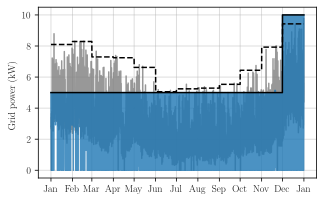

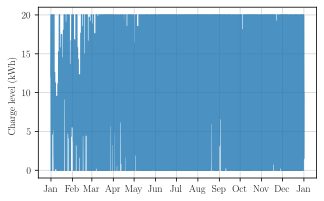

In [10]:
# Compute and print total cost with no storage
total_tou_cost, total_spot_cost, total_peak_cost = compute_total_costs(tou_prices=tou_prices, spot_prices=spot_prices, power=p_prescient, datetime_index=sim_datetime_index, peak_cost_function=tiered_peak_cost_function, N=3)
cost_prescient_tiered = total_tou_cost + total_spot_cost + total_peak_cost
print_cost_summary(total_tou_cost, total_spot_cost, total_peak_cost)

# Plot grid power
z_load = get_z_hourly_values(power=load, datetime_index=sim_datetime_index, N=3)
z_prescient_tiered = get_z_hourly_values(power=p_prescient, datetime_index=sim_datetime_index, N=3)

latexify(fig_width=5)
fig, ax = plt.subplots()
ax.plot(sim_datetime_index, load, color="tab:gray", alpha=0.8, label="No storage")
ax.plot(sim_datetime_index, p_prescient, color="tab:blue", alpha=0.8, label="20 kWh storage (prescient)")
ax.plot(sim_datetime_index, z_load, color="k", linestyle="dashed", label="$z_m$ (no storage)")
ax.plot(sim_datetime_index, z_prescient_tiered, color="k", linestyle="solid", label="$z_m$ (prescient)")
plt.ylabel("Grid power (kW)")
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# plt.savefig("figures/power_prescient.pdf")

# Plot charge level
latexify(fig_width=5)
fig, ax = plt.subplots()
ax.plot(sim_datetime_index, q_prescient[1:], color="tab:blue", alpha=0.8)
plt.ylabel("Charge level (kWh)")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# plt.savefig("figures/q_prescient.pdf")

### Tiered peak power cost: relax-and-resolve

In [ ]:
# First pass: solve relaxed problem
energy_cost, cons, p, q, u_c, u_d = create_shared_cost_and_cons(load=load, tou_prices=tou_prices, spot_prices=spot_prices, T=T, Q=Q, C=C, D=D, q_init=q_init, q_final=q_final)
z_values = compute_month_z_values(p, sim_datetime_index)

peak_power_cost = 0
for z in z_values:
    peak_power_cost += cp.maximum(83, cp.maximum(21.33 * (z - 2) + 83, 23.8 * (z - 10) + 252))

cost = energy_cost + peak_power_cost
problem = cp.Problem(cp.Minimize(cost), cons)
lb = problem.solve()

z_relax = [z.value for z in z_values]
z_upper_bounds = [get_tier_upper_bounds(z) for z in z_relax]
peak_costs = [tiered_peak_cost_function(z) for z in z_relax]

# Second pass: re-solve problem
energy_cost, cons, p, q, u_c, u_d = create_shared_cost_and_cons(load=load, tou_prices=tou_prices, spot_prices=spot_prices, T=T, Q=Q, C=C, D=D, q_init=q_init, q_final=q_final)
z_values = compute_month_z_values(p, sim_datetime_index)

peak_power_cost = 0
for i, z in enumerate(z_values):
    peak_power_cost += peak_costs[i]
    cons.append(z <= z_upper_bounds[i])

cost = energy_cost + peak_power_cost
problem = cp.Problem(cp.Minimize(cost), cons)
ub = problem.solve()

# Local search
tier_costs = np.array([83, 147, 252, 371, 490])
tier_z_upper_bounds = np.array([2, 5, 10, 15, P])
tiers = [0, 1, 2, 3, 4]
tiers_relax = [get_tier(z) for z in z_relax]

z_upper_bounds_new = z_upper_bounds.copy()
peak_costs_new = peak_costs.copy()

# Iterate over each month
for i in range(len(z_values)):
    # Reduce the tier for the month by one, if it's not already at the lowest tier
    if tiers_relax[i] > 0:
        z_upper_bounds_new[i] = tier_z_upper_bounds[tiers_relax[i] - 1]
        peak_costs_new[i] = tier_costs[tiers_relax[i] - 1]

        # Re-solve the problem with the new tier
        energy_cost, cons, p, q, u_c, u_d = create_shared_cost_and_cons(load=load, tou_prices=tou_prices, spot_prices=spot_prices, T=T, Q=Q, C=C, D=D, q_init=q_init, q_final=q_final)
        z_values = compute_month_z_values(p, sim_datetime_index)
        peak_power_cost = 0
        for j, z in enumerate(z_values):
            peak_power_cost += peak_costs_new[j]
            cons.append(z <= z_upper_bounds_new[j])
        cost = energy_cost + peak_power_cost
        problem = cp.Problem(cp.Minimize(cost), cons)
        new_result = problem.solve()

        # If the new solution is worse, revert the changes
        if new_result >= ub:
            z_upper_bounds_new[i] = z_upper_bounds[i]
            peak_costs_new[i] = peak_costs[i]

# Re-solve the problem with the new tier
energy_cost, cons, p, q, u_c, u_d = create_shared_cost_and_cons(load=load, tou_prices=tou_prices, spot_prices=spot_prices, T=T, Q=Q, C=C, D=D, q_init=q_init, q_final=q_final)
z_values = compute_month_z_values(p, sim_datetime_index)

peak_power_cost = 0
for i, z in enumerate(z_values):
    peak_power_cost += peak_costs_new[i]
    cons.append(z <= z_upper_bounds_new[i])

cost = energy_cost + peak_power_cost
problem = cp.Problem(cp.Minimize(cost), cons)
problem.solve()

power_prescient_tiered_relax = p.value
q_prescient_tiered_relax = q.value

In [ ]:
# Compute and print total cost with no storage
total_tou_cost, total_spot_cost, total_peak_cost = compute_total_costs(tou_prices=tou_prices, spot_prices=spot_prices, power=power_prescient_tiered_relax, datetime_index=sim_datetime_index, peak_cost_function=tiered_peak_cost_function, N=3)
cost_prescient_tiered_relax = total_tou_cost + total_spot_cost + total_peak_cost
print_cost_summary(total_tou_cost, total_spot_cost, total_peak_cost)

# Plot grid power
z_load = get_z_hourly_values(power=load, datetime_index=sim_datetime_index, N=3)
z_prescient_tiered_relax = get_z_hourly_values(power=power_prescient_tiered_relax, datetime_index=sim_datetime_index, N=3)

latexify(fig_width=5)
fig, ax = plt.subplots()
ax.plot(sim_datetime_index, load, color="tab:gray", alpha=0.8, label="No storage")
ax.plot(sim_datetime_index, power_prescient_tiered_relax, color="tab:blue", alpha=0.8, label="20 kWh storage")
ax.plot(sim_datetime_index, z_load, color="k", linestyle="solid", label="$z_m$ (no storage)")
ax.plot(sim_datetime_index, z_prescient_tiered_relax, color="k", linestyle="dashed", label="$z_m$ (prescient)")
plt.ylabel("Grid power (kW)")
# plt.legend(loc="upper left", ncol=2)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

In [ ]:
# Plot grid power, charge level, and electricity prices for 1 week in January
p_prescient_affine_series = pd.Series(power_prescient_affine, index=sim_datetime_index)
p_prescient_tiered_series = pd.Series(p_prescient, index=sim_datetime_index)
p_prescient_tiered_relax_series = pd.Series(power_prescient_tiered_relax, index=sim_datetime_index)
q_prescient_affine_series = pd.Series(q_prescient_affine[1:], index=sim_datetime_index)
q_prescient_tiered_series = pd.Series(q_prescient_tiered[1:], index=sim_datetime_index)
q_prescient_tiered_relax_series = pd.Series(q_prescient_tiered_relax[1:], index=sim_datetime_index)
price_series = pd.Series(spot_prices + tou_prices, index=sim_datetime_index)
datetime_index = sim_datetime_index[(sim_datetime_index >= '2022-01-03') & (sim_datetime_index < '2022-01-10')]

latexify(fig_width=5)
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(p_prescient_affine_series[datetime_index].values, color="tab:blue", label="Affine")
ax[0].plot(p_prescient_tiered_series[datetime_index].values, color="tab:orange", label="Tiered (MILP)")
ax[0].plot(p_prescient_tiered_relax_series[datetime_index].values, color="tab:green", label="Tiered (relaxation)")
ax[0].set_ylabel("Grid power (kW)")
ax[0].legend()

ax[1].plot(q_prescient_affine_series[datetime_index].values, color="tab:blue")
ax[1].plot(q_prescient_tiered_series[datetime_index].values, color="tab:orange")
ax[1].plot(q_prescient_tiered_relax_series[datetime_index].values, color="tab:green")
ax[1].set_ylabel("Charge level (kWh)")
ax[1].set_xticks(np.arange(0, 24 * 7 + 1, 24))
ax[1].set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun", "Mon"])

# Plot spot_price_series on both subplots
for axis in ax:
    ax2 = axis.twinx()
    ax2.plot(price_series[datetime_index].values, color="tab:gray", alpha=0.8, linestyle="solid")
    ax2.set_ylabel("Price (NOK/kWh)")
    ax2.yaxis.tick_right()
    ax2.grid(False)

# Align y-axis labels
fig.align_ylabels(ax)
plt.tight_layout()

### Cost versus storage capacity

In [ ]:
storage_capacities = np.linspace(0, 100)
costs_affine = np.zeros(len(storage_capacities))
costs_tiered = np.zeros_like(costs_affine)

for i, capacity in tqdm.tqdm(enumerate(storage_capacities), total=len(storage_capacities)):
    Q = capacity
    C, D, q_init, q_final = Q/2, Q/2, Q/2, Q/2

    energy_cost, cons, p, q, u_c, u_d = create_shared_cost_and_cons(load=load, tou_prices=tou_prices, spot_prices=spot_prices, T=T, Q=Q, C=C, D=D, q_init=q_init, q_final=q_final)
    z_values = compute_month_z_values(p, sim_datetime_index)

    peak_power_cost = 0
    for z in z_values:
        peak_power_cost += a * z + b

    cost = energy_cost + peak_power_cost
    problem = cp.Problem(cp.Minimize(cost), cons)
    problem.solve()
    
    assert problem.status == cp.OPTIMAL, f"Solver failed to find an optimal solution. Problem status: {problem.status}"
    costs_affine[i] = cost.value
    
    
for i, capacity in tqdm.tqdm(enumerate(storage_capacities), total=len(storage_capacities)):
    Q = capacity
    C, D, q_init, q_final = Q/2, Q/2, Q/2, Q/2

    energy_cost, cons, p, q, u_c, u_d = create_shared_cost_and_cons(load=load, tou_prices=tou_prices, spot_prices=spot_prices, T=T, Q=Q, C=C, D=D, q_init=q_init, q_final=q_final)
    z_values = compute_month_z_values(p, sim_datetime_index)

    peak_power_cost = 0
    for z in z_values:
        tier_indicator = cp.Variable(5, boolean=True)
        cons.append(z <= cp.matmul(tier_z_upper_bounds, tier_indicator))
        peak_power_cost += cp.matmul(tier_costs, tier_indicator)

    cost = energy_cost + peak_power_cost
    problem = cp.Problem(cp.Minimize(cost), cons)
    problem.solve(solver=cp.GUROBI)
    
    assert problem.status == cp.OPTIMAL, f"Solver failed to find an optimal solution. Problem status: {problem.status}"
    costs_tiered[i] = cost.value


savings_percetage_affine = (costs_affine[0] - costs_affine)/costs_affine[0] * 100
savings_percetage_tiered = (costs_tiered[0] - costs_tiered)/costs_tiered[0] * 100

latexify(fig_width=5)
plt.figure()
plt.plot(storage_capacities, savings_percetage_affine, color="k", linestyle="solid", label="Affine peak power cost")
plt.plot(storage_capacities, savings_percetage_tiered, color="k", linestyle="dashed", label="Tiered peak power cost")
plt.xlabel("Storage capacity (kWh)")
plt.ylabel("Annual savings (\%)")
plt.legend()

plt.savefig("figures/cost_vs_storage_capacity.pdf")

## Model predictive control policy

### Affine peak power cost

In [ ]:
# Constants
Q = 20
C, D, q_final, q_init = Q/2, Q/2, Q/2, Q/2
eff_s, eff_c, eff_d = 0.9995, 0.95, 0.95
P = 20 # Max power
a, b = 20.35, 83
M, L = 24, 23
H = 24*30

# Simulation window
T = 24*365
sim_datetime_index = load_data.index[sim_start_time:sim_start_time+T]

p_values = np.zeros(T)
q_values = np.zeros(T+1)
prev_N_largest_daily_powers = []

curr_max_daily_power = 0
q_values[0] = q_init
prev_datetime = sim_datetime_index[0]

# MPC loop
for t in tqdm.trange(T):
    
    # Reset N_largest_daily_powers if new month
    if prev_datetime.month != sim_datetime_index[t].month:
        prev_N_largest_daily_powers = []
    
    # Update N_largest_daily_powers and max_daily_power
    if prev_datetime.day != sim_datetime_index[t].day:
        prev_N_largest_daily_powers = update_N_largest_daily_powers(prev_N_largest_daily_powers, curr_max_daily_power)
        curr_max_daily_power = 0
    
    # Forecast loads, time-of-use prices and day-ahead prices over a horizon H
    load_forecast = make_load_forecast(load_data, load_baseline, AR_params, sim_start_time, t, H, M, L, load_min, load_max)
    spot_price_forecast = make_spot_price_forecast(spot_price_data, spot_price_baseline, sim_datetime_index, sim_start_time, t, H)
    tou_price_forecast = tou_price_data[sim_start_time+t:sim_start_time+t+H].values
    
    # Get datetimes for the horizon
    datetime_index_horizon = load_baseline.index[sim_start_time+t:sim_start_time+t+H]
    
    # Run MPC to make a plan of actions over a horizon and get the first action of the plan
    energy_cost, cons, p, q, u_c, u_d = create_shared_cost_and_cons(load=load_forecast, tou_prices=tou_price_forecast, spot_prices=spot_price_forecast, T=H, Q=Q, C=C, D=D, q_init=q_values[t], q_final=q_final)
    z_values = compute_month_z_values(p=p, datetime_index=datetime_index_horizon, prev_N_largest_daily_powers=prev_N_largest_daily_powers, curr_max_daily_power=curr_max_daily_power)

    peak_power_cost = 0
    for z in z_values:
        peak_power_cost += a * z + b

    cost = energy_cost + peak_power_cost
    problem = cp.Problem(cp.Minimize(cost), cons)
    problem.solve()

    # Execute first action and update states
    p_values[t] = p.value[0]
    q_values[t+1] =  eff_s * q_values[t] + eff_c * u_c.value[0] - u_d.value[0] / eff_d
    prev_datetime = sim_datetime_index[t]
    curr_max_daily_power = np.maximum(curr_max_daily_power, p.value[0])
    
power_mpc_affine = p_values

In [ ]:
# Compute and print total cost with no storage
total_tou_cost, total_spot_cost, total_peak_cost = compute_total_costs(tou_prices=tou_prices, spot_prices=spot_prices, power=power_mpc_affine, datetime_index=sim_datetime_index, peak_cost_function=affine_peak_cost_function, N=3)
cost_mpc_affine = total_tou_cost + total_spot_cost + total_peak_cost
print_cost_summary(total_tou_cost, total_spot_cost, total_peak_cost)

# Plot grid power
z_load = get_z_hourly_values(power=load, datetime_index=sim_datetime_index, N=3)
z_mpc_affine = get_z_hourly_values(power=power_mpc_affine, datetime_index=sim_datetime_index, N=3)

latexify(fig_width=5)
fig, ax = plt.subplots()
ax.plot(sim_datetime_index, load, color="tab:gray", alpha=0.8, label="No storage")
ax.plot(sim_datetime_index, power_mpc_affine, color="tab:blue", alpha=0.8, label="20 kWh storage (MPC)")
ax.plot(sim_datetime_index, z_load, color="k", linestyle="dashed", label="$z_m$ (no storage)")
ax.plot(sim_datetime_index, z_mpc_affine, color="k", linestyle="solid", label="$z_m$ (MPC)")
plt.ylabel("Grid power (kW)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.savefig("figures/power_mpc_affine.pdf")

#### Cost comparison

In [ ]:
print(f"Cost without storage: {cost_no_storage_affine:,.2f} NOK")
print(f"Prescient cost with 20 kWh of storage capacity: {cost_prescient_affine:,.2f} NOK")
print(f"MPC cost with 20 kWh of storage capacity: {cost_mpc_affine:,.2f} NOK")

relative_gap = (abs(cost_mpc_affine - cost_prescient_affine) / abs(cost_prescient_affine)) * 100
print(f"Relative gap between MPC cost and prescient cost: {relative_gap:.2f}%")
print(f"Annual savings with MPC policy and 20 kWh of storage capacity: {cost_no_storage_affine-cost_mpc_affine:.2f} NOK ({100 * (cost_no_storage_affine-cost_mpc_affine) / cost_no_storage_affine:.2f}%)")

### Tiered peak power cost

In [ ]:
p_values = np.zeros(T)
q_values = np.zeros(T+1)
prev_N_largest_daily_powers = []

curr_max_daily_power = 0
q_values[0] = q_init
prev_datetime = sim_datetime_index[0]

# MPC loop
for t in tqdm.trange(T):
    
    # Reset N_largest_daily_powers if new month
    if prev_datetime.month != sim_datetime_index[t].month:
        prev_N_largest_daily_powers = []
    
    # Update N_largest_daily_powers and max_daily_power
    if prev_datetime.day != sim_datetime_index[t].day:
        prev_N_largest_daily_powers = update_N_largest_daily_powers(prev_N_largest_daily_powers, curr_max_daily_power)
        curr_max_daily_power = 0
    
    # Forecast loads, time-of-use prices and day-ahead prices over a horizon H
    load_forecast = make_load_forecast(load_data, load_baseline, AR_params, sim_start_time, t, H, M, L, load_min, load_max)
    spot_price_forecast = make_spot_price_forecast(spot_price_data, spot_price_baseline, sim_datetime_index, sim_start_time, t, H)
    tou_price_forecast = tou_price_data[sim_start_time+t:sim_start_time+t+H].values
    
    # Get datetimes for the horizon
    datetime_index_horizon = load_baseline.index[sim_start_time+t:sim_start_time+t+H]
    
    # # First pass: solve relaxed problem
    # energy_cost, cons, p, q, u_c, u_d = create_shared_cost_and_cons(load=load_forecast, tou_prices=tou_price_forecast, spot_prices=spot_price_forecast, T=H, Q=Q, C=C, D=D, q_init=q_values[t], q_final=q_final)
    # z_values = compute_month_z_values(p=p, datetime_index=datetime_index_horizon, prev_N_largest_daily_powers=prev_N_largest_daily_powers, curr_max_daily_power=curr_max_daily_power)

    # peak_power_cost = 0
    # for z in z_values:
    #     peak_power_cost += cp.maximum(83, cp.maximum(21.33 * (z - 2) + 83, 23.8 * (z - 10) + 252))

    # cost = energy_cost + peak_power_cost
    # problem = cp.Problem(cp.Minimize(cost), cons)
    # problem.solve()

    # z_relax = [z.value for z in z_values]
    # z_upper_bounds = [get_tier_upper_bounds(z) for z in z_relax]
    # peak_costs = [tiered_peak_cost_function(z) for z in z_relax]

    # # Second pass: re-solve problem
    # energy_cost, cons, p, q, u_c, u_d = create_shared_cost_and_cons(load=load_forecast, tou_prices=tou_price_forecast, spot_prices=spot_price_forecast, T=H, Q=Q, C=C, D=D, q_init=q_values[t], q_final=q_final)
    # z_values = compute_month_z_values(p=p, datetime_index=datetime_index_horizon, prev_N_largest_daily_powers=prev_N_largest_daily_powers, curr_max_daily_power=curr_max_daily_power)

    # peak_power_cost = 0
    # for i, z in enumerate(z_values):
    #     peak_power_cost += peak_costs[i]
    #     cons.append(z <= z_upper_bounds[i])

    # cost = energy_cost + peak_power_cost
    # problem = cp.Problem(cp.Minimize(cost), cons)
    # problem.solve()
    
    #########################################################
    
    # # First pass: solve relaxed problem
    # energy_cost, cons, p, q, u_c, u_d = create_shared_cost_and_cons(load=load_forecast, tou_prices=tou_price_forecast, spot_prices=spot_price_forecast, T=H, Q=Q, C=C, D=D, q_init=q_values[t], q_final=q_final)
    # z_values = compute_month_z_values(p=p, datetime_index=datetime_index_horizon, prev_N_largest_daily_powers=prev_N_largest_daily_powers, curr_max_daily_power=curr_max_daily_power)

    # peak_power_cost = 0
    # for z in z_values:
    #     peak_power_cost += cp.maximum(83, cp.maximum(21.33 * (z - 2) + 83, 23.8 * (z - 10) + 252))

    # cost = energy_cost + peak_power_cost
    # problem = cp.Problem(cp.Minimize(cost), cons)
    # lb = problem.solve()

    # z_relax = [z.value for z in z_values]
    # z_upper_bounds = [get_tier_upper_bounds(z) for z in z_relax]
    # peak_costs = [tiered_peak_cost_function(z) for z in z_relax]

    # # Second pass: re-solve problem
    # energy_cost, cons, p, q, u_c, u_d = create_shared_cost_and_cons(load=load_forecast, tou_prices=tou_price_forecast, spot_prices=spot_price_forecast, T=H, Q=Q, C=C, D=D, q_init=q_values[t], q_final=q_final)
    # z_values = compute_month_z_values(p=p, datetime_index=datetime_index_horizon, prev_N_largest_daily_powers=prev_N_largest_daily_powers, curr_max_daily_power=curr_max_daily_power)

    # peak_power_cost = 0
    # for i, z in enumerate(z_values):
    #     peak_power_cost += peak_costs[i]
    #     cons.append(z <= z_upper_bounds[i])

    # cost = energy_cost + peak_power_cost
    # problem = cp.Problem(cp.Minimize(cost), cons)
    # ub = problem.solve()

    # # Local search
    # tier_costs = np.array([83, 147, 252, 371, 490])
    # tier_z_upper_bounds = np.array([2, 5, 10, 15, P])
    # tiers = [0, 1, 2, 3, 4]
    # tiers_relax = [get_tier(z) for z in z_relax]

    # z_upper_bounds_new = z_upper_bounds.copy()
    # peak_costs_new = peak_costs.copy()

    # # Iterate over each month
    # for i in range(len(z_values)):
    #     # Reduce the tier for the month by one, if it's not already at the lowest tier
    #     if tiers_relax[i] > 0:
    #         z_upper_bounds_new[i] = tier_z_upper_bounds[tiers_relax[i] - 1]
    #         peak_costs_new[i] = tier_costs[tiers_relax[i] - 1]

    #         # Re-solve the problem with the new tier
    #         energy_cost, cons, p, q, u_c, u_d = create_shared_cost_and_cons(load=load_forecast, tou_prices=tou_price_forecast, spot_prices=spot_price_forecast, T=H, Q=Q, C=C, D=D, q_init=q_values[t], q_final=q_final)
    #         z_values = compute_month_z_values(p=p, datetime_index=datetime_index_horizon, prev_N_largest_daily_powers=prev_N_largest_daily_powers, curr_max_daily_power=curr_max_daily_power)
    #         peak_power_cost = 0
    #         for j, z in enumerate(z_values):
    #             peak_power_cost += peak_costs_new[j]
    #             cons.append(z <= z_upper_bounds_new[j])
    #         cost = energy_cost + peak_power_cost
    #         problem = cp.Problem(cp.Minimize(cost), cons)
    #         new_result = problem.solve()

    #         # If the new solution is worse, revert the changes
    #         if new_result >= ub:
    #             z_upper_bounds_new[i] = z_upper_bounds[i]
    #             peak_costs_new[i] = peak_costs[i]

    # # Re-solve the problem with the new tier
    # energy_cost, cons, p, q, u_c, u_d = create_shared_cost_and_cons(load=load_forecast, tou_prices=tou_price_forecast, spot_prices=spot_price_forecast, T=H, Q=Q, C=C, D=D, q_init=q_values[t], q_final=q_final)
    # z_values = compute_month_z_values(p=p, datetime_index=datetime_index_horizon, prev_N_largest_daily_powers=prev_N_largest_daily_powers, curr_max_daily_power=curr_max_daily_power)

    # peak_power_cost = 0
    # for i, z in enumerate(z_values):
    #     peak_power_cost += peak_costs_new[i]
    #     cons.append(z <= z_upper_bounds_new[i])

    # cost = energy_cost + peak_power_cost
    # problem = cp.Problem(cp.Minimize(cost), cons)
    # problem.solve()
    
    ##############################################################################################################
    energy_cost, cons, p, q, u_c, u_d = create_shared_cost_and_cons(load=load_forecast, tou_prices=tou_price_forecast, spot_prices=spot_price_forecast, T=H, Q=Q, C=C, D=D, q_init=q_values[t], q_final=q_final)
    z_values = compute_month_z_values(p=p, datetime_index=datetime_index_horizon, prev_N_largest_daily_powers=prev_N_largest_daily_powers, curr_max_daily_power=curr_max_daily_power)

    P = 20
    tier_costs = np.array([83, 147, 252, 371, 490])
    tier_z_upper_bounds = np.array([2, 5, 10, 15, P])
    peak_power_cost = 0

    for z in z_values:
        tier_indicator = cp.Variable(5, boolean=True)
        cons.append(z <= cp.matmul(tier_z_upper_bounds, tier_indicator))
        peak_power_cost += cp.matmul(tier_costs, tier_indicator)

    cost = energy_cost + peak_power_cost
    problem = cp.Problem(cp.Minimize(cost), cons)
    problem.solve(solver=cp.GUROBI)

    power_prescient_tiered = p.value
    q_prescient_tiered = q.value
    
    
    # Execute first action and update states
    p_values[t] = p.value[0]
    q_values[t+1] =  eff_s * q_values[t] + eff_c * u_c.value[0] - u_d.value[0] / eff_d
    prev_datetime = sim_datetime_index[t]
    curr_max_daily_power = np.maximum(curr_max_daily_power, p.value[0])
    
power_mpc_tiered = p_values

In [ ]:
# Compute and print total cost with no storage
total_tou_cost, total_spot_cost, total_peak_cost = compute_total_costs(tou_prices=tou_prices, spot_prices=spot_prices, power=power_mpc_tiered, datetime_index=sim_datetime_index, peak_cost_function=tiered_peak_cost_function, N=3)
cost_mpc_tiered = total_tou_cost + total_spot_cost + total_peak_cost
print_cost_summary(total_tou_cost, total_spot_cost, total_peak_cost)

# Plot grid power
z_load = get_z_hourly_values(power=load, datetime_index=sim_datetime_index, N=3)
z_mpc_tiered = get_z_hourly_values(power=power_mpc_tiered, datetime_index=sim_datetime_index, N=3)

latexify(fig_width=5)
fig, ax = plt.subplots()
ax.plot(sim_datetime_index, load, color="tab:gray", alpha=0.8, label="No storage")
ax.plot(sim_datetime_index, power_mpc_tiered, color="tab:blue", alpha=0.8, label="20 kWh storage (MPC)")
ax.plot(sim_datetime_index, z_load, color="k", linestyle="dashed", label="$z_m$ (no storage)")
ax.plot(sim_datetime_index, z_mpc_tiered, color="k", linestyle="solid", label="$z_m$ (MPC)")
plt.ylabel("Grid power (kW)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.savefig("figures/power_mpc_tiered.pdf")

#### Cost comparison

In [ ]:
print(f"Cost without storage: {cost_no_storage_tiered:,.2f} NOK")
print(f"Prescient cost with 20 kWh of storage capacity: {cost_prescient_tiered:,.2f} NOK")
print(f"MPC cost with 20 kWh of storage capacity: {cost_mpc_tiered:,.2f} NOK")

relative_gap = (abs(cost_mpc_tiered - cost_prescient_tiered) / abs(cost_prescient_tiered)) * 100
print(f"Relative gap between MPC cost and prescient cost: {relative_gap:.2f}%")
print(f"Annual savings with MPC policy and 20 kWh of storage capacity: {cost_no_storage_tiered-cost_mpc_tiered:.2f} NOK ({100 * (cost_no_storage_tiered-cost_mpc_tiered) / cost_no_storage_tiered:.2f}%)")